loan_amount                    0.797749
funded_amount                  0.797749
funded_amount_inv              0.805574
instalment                     0.989493
annual_inc                     8.766707
dti                            0.194755
delinq_2yrs                    5.330269
inq_last_6mths                 3.284331
open_accounts                  1.058217
total_accounts                 0.777275
out_prncp                      2.358973
out_prncp_inv                  2.359415
total_payment                  1.257216
total_payment_inv              1.244940
total_rec_prncp                1.248463
total_rec_int                  2.194036
total_rec_late_fee            13.186441
recoveries                    14.133929
collection_recovery_fee       27.505679
last_payment_amount            2.478841
collections_12_mths_ex_med    20.385589
dtype: float64


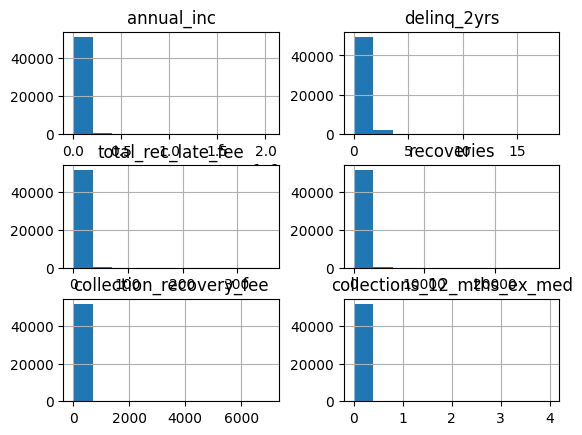

In [3]:
import db_utils
import yaml, pandas as pd, numpy as np

'''
Loading the data in the yaml file and saving it as 
a csv file on the local machine
'''

with open('credentials.yaml') as file:
    credentials_dict = yaml.safe_load(file)
    
credentials = db_utils.RDSDatabaseConnector(credentials_dict)
loan_payments = credentials.initialise_database()
credentials.save_file(loan_payments, 'new_file.csv')


'''
Loading the data and adjusting the data types of each column of the dataframe
where needed as well as ensuring the formatting of the data (specifically those 
that consist of dates) are all the same
'''

database = db_utils.load_csv('new_file.csv')
cleaned_data = db_utils.DataTransform(database)

date_data = ['issue_date', 'earliest_credit_line', 'last_payment_date', 'next_payment_date',
             'last_credit_pull_date']

categorical_data = ['member_id', 'term', 'int_rate', 'grade', 'sub_grade', 'employment_length', 'home_ownership', 'verification_status', 'loan_status', 
                    'payment_plan', 'purpose', 'policy_code', 'application_type']

non_numeric_data = date_data + categorical_data 
column_headings = database.columns.values.tolist()
numeric_data = [column for column in column_headings if column not in non_numeric_data]

for date_column in date_data:
    database, date_column = cleaned_data.date_data(database, date_column)

for categories in categorical_data:
    database, categories = cleaned_data.change_type(database, categories, 'category')


'''
Dropping columns whose data consists of more than 50% of null values
and filling in the null values for the other columns with null values
'''

df_info = db_utils.DataFrameInfo(database)
df_transform = db_utils.DataFrameTransform(database)
df_plot = db_utils.Plotter(database)

for column in column_headings:
    null_vals, null_percentage = df_info.missing(database, column)
    if null_percentage > float(50):
        database = database.drop(column, axis=1)

database = database.sort_values(by=['sub_grade'])
database['int_rate'] = database['int_rate'].ffill()
database['funded_amount'] = database.loc[:, 'loan_amount']
fill_values = {'collections_12_mths_ex_med': 0, 'term': database['term'].mode()[0]}
database = df_transform.fill_null(database, values= fill_values)

last_payment_date_list= db_utils.make_list(database, 'last_payment_date')
last_credit_pull_date_list = db_utils.make_list(database, 'last_credit_pull_date')

for index in range(54231):
    if pd.isnull(last_payment_date_list[index]):
        last_payment_date_list[index] = last_credit_pull_date_list[index]
    
    if pd.isnull(last_credit_pull_date_list[index]):
        last_credit_pull_date_list[index] = last_payment_date_list[index]

database['last_payment_date'] = last_payment_date_list
database['last_credit_pull_date'] = last_credit_pull_date_list
database = database.dropna(axis = 0)


'''
Finding the skew of the columns made of integers and floats in the
dataframe
'''

df_skew = database.skew(axis= 0, numeric_only= True)
skewed_data = database[[skewed_col for skewed_col, skew_value in df_skew.items() if skew_value > 5]]
df_plot.plot_hist(skewed_data)
